In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import ast
import os
from tensorflow import keras
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.metrics import categorical_accuracy, categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from glob import glob
from PIL import Image, ImageDraw 
from dask import bag
%matplotlib inline

NUM_CLASS= 340
BASE_SIZE=256
size=32
imgs_per_class=2000
train_path = 'train_simplified/'

In [2]:
input_files = glob(train_path+'*.csv')
len(input_files)

340

In [3]:
sample_drawings=[pd.read_csv(file,nrows=5) for file in input_files[0:3]]
sample_df = pd.DataFrame(np.concatenate([df[df.recognized==True] for df in sample_drawings]),
                         columns=sample_drawings[0].columns.values)

In [4]:
sample_df.head()

,countrycode,drawing,key_id,recognized,timestamp,word
0,US,"[[[167, 109, 80, 69, 58, 31, 57, 117, 99, 52, ...",5.1528e+15,True,12:07.3,airplane
1,US,"[[[90, 88, 95, 104, 112, 122], [65, 31, 12, 0,...",6.57701e+15,True,08:35.2,airplane
2,US,"[[[82, 49, 15, 4, 0, 5, 30, 85, 89, 93, 112, 1...",5.64322e+15,True,35:17.5,airplane
3,IL,"[[[64, 38, 23, 8, 0, 6, 26, 68], [74, 77, 84, ...",6.67005e+15,True,11:11.7,airplane
4,US,"[[[111, 148, 161, 175, 199, 218, 231, 236, 234...",5159910851477504,True,2017-03-21 13:02:16.246170,alarm clock


In [5]:
sample_diagram_points = [ast.literal_eval(points) for points in sample_df.drawing.values]

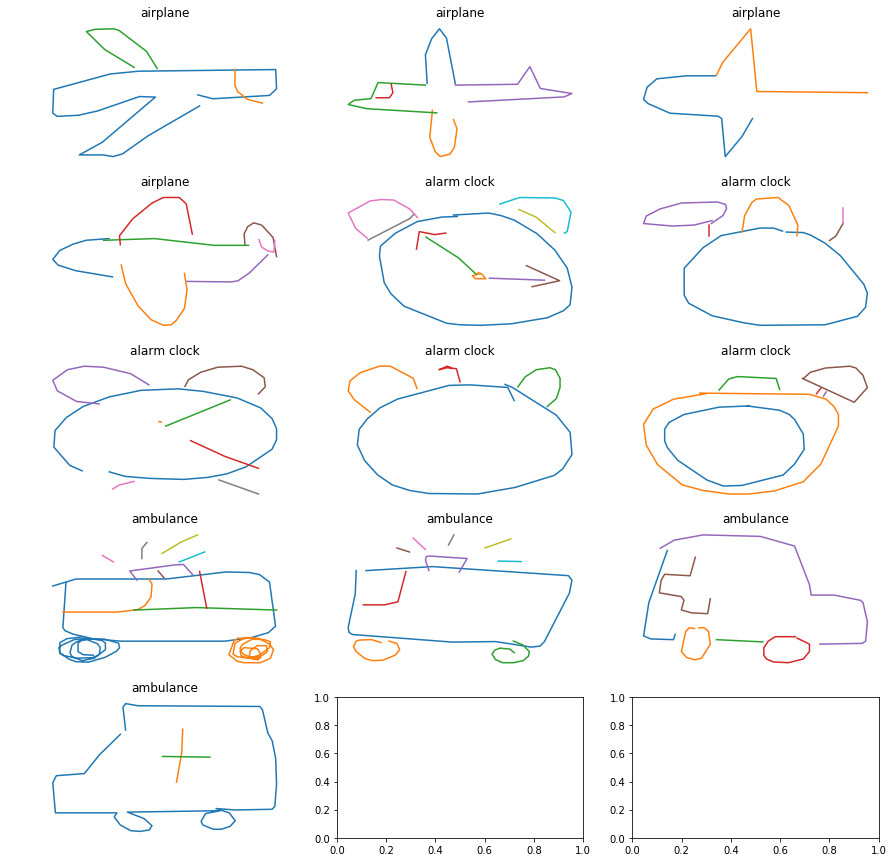

In [6]:
f,axs= plt.subplots(5,3,frameon=False,figsize=(15,15))
for i,drawing in enumerate(sample_diagram_points):
    for j,strokes in enumerate(drawing):
        ax=axs[i//3,i%3]
        ax.plot(strokes[0],np.negative(strokes[1]))
        ax.set(title=sample_df.iloc[i].word)
        ax.axis('off')
plt.show()

In [7]:
categories = [file.replace('.csv','').replace(' ','_') for file in os.listdir(train_path)]
categories

['airplane',
 'alarm_clock',
 'ambulance',
 'angel',
 'animal_migration',
 'ant',
 'anvil',
 'apple',
 'arm',
 'asparagus',
 'axe',
 'backpack',
 'banana',
 'bandage',
 'barn',
 'baseball_bat',
 'baseball',
 'basket',
 'basketball',
 'bat',
 'bathtub',
 'beach',
 'bear',
 'beard',
 'bed',
 'bee',
 'belt',
 'bench',
 'bicycle',
 'binoculars',
 'bird',
 'birthday_cake',
 'blackberry',
 'blueberry',
 'book',
 'boomerang',
 'bottlecap',
 'bowtie',
 'bracelet',
 'brain',
 'bread',
 'bridge',
 'broccoli',
 'broom',
 'bucket',
 'bulldozer',
 'bus',
 'bush',
 'butterfly',
 'cactus',
 'cake',
 'calculator',
 'calendar',
 'camel',
 'camera',
 'camouflage',
 'campfire',
 'candle',
 'cannon',
 'canoe',
 'car',
 'carrot',
 'castle',
 'cat',
 'ceiling_fan',
 'cell_phone',
 'cello',
 'chair',
 'chandelier',
 'church',
 'circle',
 'clarinet',
 'clock',
 'cloud',
 'coffee_cup',
 'compass',
 'computer',
 'cookie',
 'cooler',
 'couch',
 'cow',
 'crab',
 'crayon',
 'crocodile',
 'crown',
 'cruise_ship',
 

In [8]:
def draw_it(strokes):
    image = Image.new("P", (256,256), color=255)
    image_draw = ImageDraw.Draw(image)
    for stroke in ast.literal_eval(strokes):
        for i in range(len(stroke[0])-1):
            image_draw.line([stroke[0][i], 
                             stroke[1][i],
                             stroke[0][i+1], 
                             stroke[1][i+1]],
                            fill=0, width=5)
    image = image.resize((size, size))
    return np.array(image)/255.

In [ ]:
%%timeit

training_data = []
for i,file in enumerate(input_files):
    file_data = pd.read_csv(file,usecols=['drawing', 'recognized'], nrows=imgs_per_class+500)
    file_data = file_data[file_data.recognized==True].head(imgs_per_class)
    imagebag = bag.from_sequence(file_data.drawing.values).map(draw_it)
    file_data_array = np.array(imagebag.compute())
    file_data_array = np.reshape(file_data_array,(imgs_per_class,-1))
    category_array = np.full((file_data.shape[0],1),i)
    file_data_array = np.concatenate((category_array,file_data_array),axis=1)
    training_data.append(file_data_array)
training_data = np.array([training_data.pop() for i in np.arange(NUM_CLASS)])
training_data = np.reshape((-1,size*size+1))